In [16]:
import numpy as np
import networkx as nx
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset
from rouge import Rouge
import spacy 
import heapq
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
dataset = load_dataset("cnn_dailymail", "3.0.0")
nlp = spacy.load("en_core_web_sm")

In [18]:
def preprocess_text(text):
    # usuwanie znaków specjalnych i typowych dla datasetu fragmentów
    text = text.replace("(CNN)", "").replace("--", "").replace("''", '"')
    # tokenizacja tekstu na zdania
    sentences = sent_tokenize(text)
    
    # to wywalone bo jest w spacy (token.is_stop)
    #stop_words = set(stopwords.words("english"))
    preprocessed = []
    
    for sent in sentences:
        doc = nlp(sent.lower())
        cleaned_words = []
        
        for token in doc:
            # Uwzgledniamy tylko rzeczowniki, czasowniki, przymiotniki, przysłówki 
            # (moze trzeba inaczej bo kiepskie wyniki)
            if (token.is_alpha and 
                not token.is_stop and 
                token.pos_ in {"NOUN", "VERB", "ADJ", "ADV"}):
                cleaned_words.append(token.lemma_)
        
        preprocessed.append(" ".join(cleaned_words))
    
    return preprocessed, sentences

In [19]:
def textrank_algorithm(article, 
                    num_sentences=5, 
                    damping_factor=0.85, 
                    similarity_threshold=0.1, 
                    max_iter=1000, 
                    tol=1e-6): # dalem tu jakies domyslne, mozna wywalic 
    preprocessed, original_sentences = preprocess_text(article)
    
    # TF-IDF, potem do eksperymentu damy tez embeddingi, np. BERT
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(preprocessed)
    # obliczamy podobieństwo każdego zdania do każdego zdania i usuwamy self-similarity
    sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    np.fill_diagonal(sim_matrix, 0)

    # usuwamy podobieństwa ponizej thresholda (nie sa wazne dla sensu)
    sim_matrix[sim_matrix < similarity_threshold] = 0  
    
    # budujemy graf i smazymy pagerank
    graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(graph, 
                        alpha=damping_factor, 
                        max_iter=max_iter, 
                        tol=tol)
    
    
    # Sortowanie według wartości pagerank
    ranked_sentences = sorted(((scores[i], i) for i in range(len(original_sentences))), reverse=True)
    ranked_indices = [ranked_sentences[i][1] for i in range(min(num_sentences, len(ranked_sentences)))]
    # jakby za wolno liczylo odkomentowac dolne i zakomentowac gorne
    # ranked_indices = heapq.nlargest(num_sentences, 
    #                                range(len(scores)), 
    #                                key=lambda i: scores[i])
    



    ranked_indices.sort()
    
    return " ".join([original_sentences[i] for i in ranked_indices])

In [20]:
def evaluate_summaries(dataset, 
                    num_articles=10, 
                    num_sentences=5, 
                    damping_factor=0.85, 
                    similarity_threshold=0.1, 
                    max_iter=1000, 
                    tol=1e-6):
    rouge = Rouge()
    results = []
    
    for i in range(num_articles):
        article = dataset["train"][i]["article"]
        reference = dataset["train"][i]["highlights"]
        
        summary = textrank_algorithm(article,
                    num_sentences=num_sentences, 
                    damping_factor=damping_factor, 
                    similarity_threshold=similarity_threshold, 
                    max_iter=max_iter, 
                    tol=tol)
        
        # ewaluacja modelu za pomoca 3 rogue.
        scores = rouge.get_scores(summary, reference)[0]
        
        # Zapis wyników
        results.append({
            "article_id": i+1,
            "summary": summary,
            "reference": reference,
            "rouge-1": scores["rouge-1"]["f"],
            "rouge-2": scores["rouge-2"]["f"],
            "rouge-l": scores["rouge-l"]["f"]
        })
        
        print(f"Artykuł {i+1}:")
        print("Podsumowanie:", summary)
        print("Docelowy highlight:", reference)
        print("ROUGE-L:", scores["rouge-l"]["f"])
        print("\n" + "-"*50 + "\n")
    
    df = pd.DataFrame(results)
    df.to_csv("textrank_evaluation.csv", index=False)
    
    return df

In [21]:
# tu na wejsciu ile artykulów streszczamy i jakie hiperparametry, na razie dalem domyslne
results_df = evaluate_summaries(dataset, num_articles=10)
print("Średnie wyniki ROUGE:")
print(results_df[["rouge-1", "rouge-2", "rouge-l"]].mean())

Artykuł 1:
Podsumowanie: Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "People are always looking to say 'kid star goes off the rails,'" he told reporters last month. His latest outing as the boy wizard in "Harry Potter and the Order of the Phoenix" is breaking records on both sides of the Atlantic and he will reprise the role in the last two films. Watch I-Reporter give her review of Potter's latest » . Meanwhile, he is braced for even closer media scrutiny now that he's legally an adult: "I just think I'm going to be more sort of fair game," he told Reuters.
Docelowy highlight: Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fu

In [ ]:
# kod do 2 pytania eksperymentalnego
def create_length_subsets(dataset, splits=[2000, 5000, 8000]):
    # tworzymy podzbiory po ilosci znakow w artykule
    subsets = {
        "short": {"articles": [], "highlights": []},
        "medium": {"articles": [], "highlights": []},
        "long": {"articles": [], "highlights": []}
    }
    
    for example in dataset["train"]:
        char_count = len(example["article"])
        
        if char_count <= splits[0]:
            key = "short"
        elif splits[0] < char_count <= splits[1]:
            key = "medium"
        elif splits[1] < char_count <= splits[2]:
            key = "long"
        else:
            continue  # Pomijamy artykuły > 8000 znaków
            
        subsets[key]["articles"].append(example["article"])
        subsets[key]["highlights"].append(example["highlights"])
    
    print("Rozkład długości:")
    print(f"- Krótkie: {len(subsets['short']['articles'])} artykułów")
    print(f"- Średnie: {len(subsets['medium']['articles'])} artykułów")
    print(f"- Długie: {len(subsets['long']['articles'])} artykułów")
    
    return subsets

Rozkład długości:
- Krótkie: 37122 artykułów
- Średnie: 173617 artykułów
- Długie: 62698 artykułów


In [23]:
def evaluate_on_subsets(subsets, num_samples=100):
    results = {}
    rouge = Rouge()
    params = { #parametry do poszczegolnych dlugosci zdan
        "short": {
            "num_sentences": 3,
            "damping_factor": 0.85,
            "similarity_threshold": 0.1,
            "max_iter": 1000,
            "tol": 1e-6
        },
        "medium": {
            "num_sentences": 5,
            "damping_factor": 0.85,
            "similarity_threshold": 0.15,
            "max_iter": 1000,
            "tol": 1e-6
        },
        "long": {
            "num_sentences": 7,
            "damping_factor": 0.8,
            "similarity_threshold": 0.2,
            "max_iter": 2000,
            "tol": 1e-8
        }}
    
    for length_key in ["short", "medium", "long"]:
        scores = []
        for art, ref in zip(subsets[length_key]["articles"][:num_samples], 
                          subsets[length_key]["highlights"][:num_samples]):
            try:
                summary = textrank_algorithm(
                    art,
                    num_sentences=params[length_key]["num_sentences"],
                    damping_factor=params[length_key]["damping_factor"],
                    similarity_threshold=params[length_key]["similarity_threshold"],
                    max_iter=params[length_key]["max_iter"],
                    tol=params[length_key]["tol"]
                )
                if summary.strip():
                    scores.append(rouge.get_scores(summary, ref)[0]["rouge-l"]["f"])
            except Exception as e:
                print(f"Błąd dla {length_key}: {str(e)}")
                continue
                
        results[length_key] = np.mean(scores) if scores else 0
    
    return results



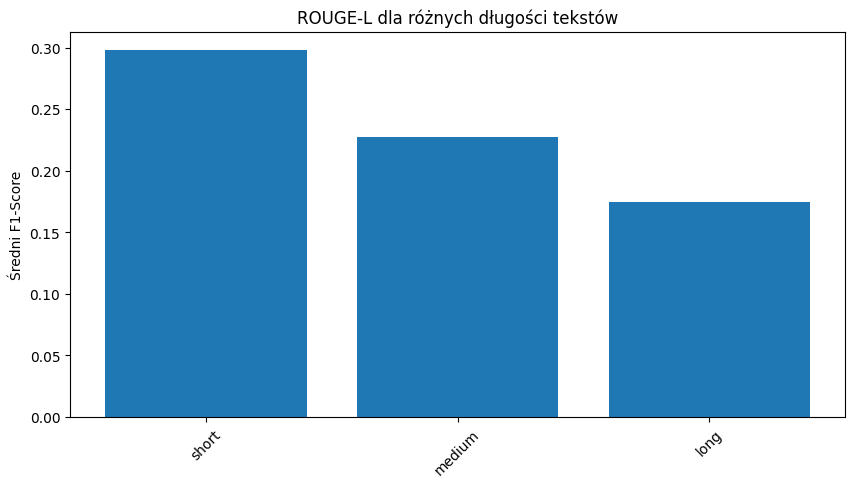

In [ ]:
subsets = create_length_subsets(dataset)
results_exp2 = evaluate_on_subsets(subsets)
plt.figure(figsize=(10, 5))
plt.bar(results_exp2.keys(), results_exp2.values())
plt.title("ROUGE-L dla różnych długości tekstów")
plt.ylabel("Średni F1-Score")
plt.xticks(rotation=45)
plt.show()

EWENTUALNE TODO:

Twoje wyniki wskazują, że model nie wybiera optymalnych zdań, ale nie są beznadziejne. Aby je poprawić:

Mniej agresywny preprocessing,

Optymalizacja hiperparametrów,

Eksperymenty z lepszymi reprezentacjami zdań.